<a href="https://colab.research.google.com/github/SivaKarthikPara/CustomerSegRFM/blob/master/Customer_segmentation_based_on_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [217]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [219]:
df = pd.read_csv('CustomerRFM.csv')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2009 08:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
195,536388,22469,HEART OF WICKER SMALL,12,01/12/2010 09:59,1.65,16250,United Kingdom
196,536388,22242,5 HOOK HANGER MAGIC TOADSTOOL,12,01/12/2010 09:59,1.65,16250,United Kingdom
197,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6,01/12/2010 10:03,8.50,12431,Australia
198,536389,21622,VINTAGE UNION JACK CUSHION COVER,8,01/12/2010 10:03,4.95,12431,Australia


In [220]:
#find the coutry in which each of the customer has made purchase
customer_country=df[['Country','CustomerID']].drop_duplicates()
customer_country
#remove null values
df = df[pd.notnull(df['CustomerID'])]
#removes negative values
df.Quantity.min()
df = df[(df['Quantity']>0)]
df.Quantity.min()
#computes totalprice for monetary calculation
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
NOW = dt.datetime(2011,9,10)
#changing date format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [181]:
# from google.colab import drive
# drive.mount('/content/drive')
# dc = df.groupby('CustomerID')
# dc.first()

In [221]:
##calculate the recency, frequency and monetary_value

rfmTable=df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})

##Renaming columns

rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary_value'}, inplace=True)
rfmTable


,recency,frequency,monetary_value
CustomerID,,,
12431,605,3,105.60
12583,605,20,855.86
13047,605,17,366.63
13748,605,1,204.00
14688,616,19,444.98
15100,605,1,350.40
15291,605,2,328.80
15311,605,35,449.98
16029,605,8,3702.12


In [222]:

rfmTable['recency'] = rfmTable['recency'].astype(int)
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable
segmented_rfm 
# quantiles


,recency,frequency,monetary_value
CustomerID,,,
12431,605,3,105.60
12583,605,20,855.86
13047,605,17,366.63
13748,605,1,204.00
14688,616,19,444.98
15100,605,1,350.40
15291,605,2,328.80
15311,605,35,449.98
16029,605,8,3702.12


In [223]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [224]:
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [225]:
#R score calculation

segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
# F Score calculation
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
#M score calculation
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))


# R= np.asarray(segmented_rfm[['r_quartile']])
# R_mean=np.mean(R);
# F= np.asarray(segmented_rfm[['f_quartile']])
# F_mean=np.mean(F);
# M= np.asarray(segmented_rfm[['m_quartile']])
# M_mean=np.mean(M);
# final=R_mean+F_mean+M_mean
# with open('output1.txt', 'w') as file:
#     file.write(str(final))

In [226]:
#combine RFM score
 
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str)+ segmented_rfm.f_quartile.map(str)+ segmented_rfm.m_quartile.map(str)
 
segmented_rfm.head()

segmented_rfm

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12431,605,3,105.60,1,3,4,134
12583,605,20,855.86,1,1,1,111
13047,605,17,366.63,1,2,3,123
13748,605,1,204.00,1,4,4,144
14688,616,19,444.98,4,1,2,412
15100,605,1,350.40,1,4,3,143
15291,605,2,328.80,1,4,3,143
15311,605,35,449.98,1,1,2,112
16029,605,8,3702.12,1,3,1,131


In [227]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12583,605,20,855.86,1,1,1,111
17850,605,45,725.44,1,1,1,111


In [228]:

kmeans = KMeans(n_clusters=3, max_iter=5)
kmeans.fit(segmented_rfm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=5,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [229]:
kmeans.labels_

array([0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0], dtype=int32)

In [ ]:

# ssd = []
# range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
# for num_clusters in range_n_clusters:
#     kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
#     kmeans.fit(segmented_rfm)
    
#     ssd.append(kmeans.inertia_)
    
# # plot the SSDs for each n_clusters
# plt.plot(ssd)

In [144]:
# Outlier Analysis of Amount Frequency and Recency

# attributes = ['recency','frequency','monetary_value']
# plt.rcParams['figure.figsize'] = [5,5]
# sns.boxplot(data = segmented_rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
# plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
# plt.ylabel("Range")
# plt.xlabel("RFM")

In [206]:
# X=segmented_rfm.iloc[:,[0,1,2]].values
# X

In [205]:
# ##Fitting kmeans to the dataset with K=4
# km4=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
# y_means = km4.fit_predict(X)

In [204]:
# #Visualizing the clusters for k=4
# plt.scatter(X[y_means==0,0],X[y_means==0,1],s=50, c='purple',label='Cluster1')
# plt.scatter(X[y_means==1,0],X[y_means==1,1],s=50, c='blue',label='Cluster2')
# plt.scatter(X[y_means==2,0],X[y_means==2,1],s=50, c='green',label='Cluster3')
# plt.scatter(X[y_means==3,0],X[y_means==3,1],s=50, c='cyan',label='Cluster4')

In [230]:
# assign the label
segmented_rfm['Cluster_Id'] = kmeans.labels_
segmented_rfm.head(100)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Cluster_Id
CustomerID,,,,,,,,
12431,605,3,105.60,1,3,4,134,0
12583,605,20,855.86,1,1,1,111,2
13047,605,17,366.63,1,2,3,123,0
13748,605,1,204.00,1,4,4,144,0
14688,616,19,444.98,4,1,2,412,0
15100,605,1,350.40,1,4,3,143,0
15291,605,2,328.80,1,4,3,143,0
15311,605,35,449.98,1,1,2,112,0
16029,605,8,3702.12,1,3,1,131,1


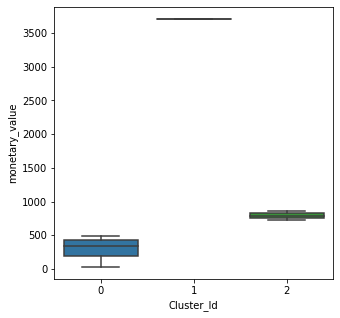

In [231]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='monetary_value', data=segmented_rfm)

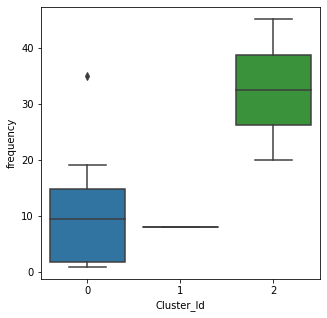

In [234]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='frequency', data=segmented_rfm)

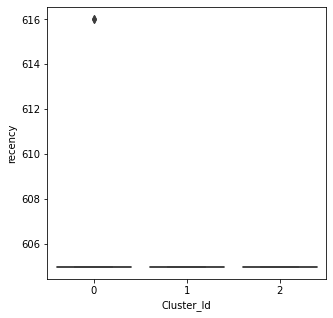

In [235]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='recency', data=segmented_rfm)